In [2]:
import keras
from keras import layers, ops, KerasTensor, random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflowjs as tfjs

os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255

In [38]:
def sample_vae(mean: KerasTensor, log_var: KerasTensor) -> KerasTensor:
    std_dev = ops.exp(0.5*log_var)
    eps = random.normal(shape=ops.shape(mean))
    z = mean + eps*std_dev
    return z, mean, log_var

# adapted from https://keras.io/examples/generative/vae/
class VAE(keras.Model):
    def __init__(self, latent_dims=2):
        super().__init__()
        # adapted from https://keras.io/examples/generative/vae/
        self.encoder = keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2*latent_dims),
        ])
        self.encoder.summary()

        # adapted from https://keras.io/examples/generative/vae/
        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dims,)),
            layers.Dense(7*7*64, activation="relu"), # the conv was (7,7,64), so shape to that
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2DTranspose(1, 3, strides=1, padding="same", activation="sigmoid"),
        ])
        self.decoder.summary()

    def call(self, x):
        x = self.encoder(x)
        [log_var, mean] = keras.ops.split(x, 2, axis=-1)
        z, mean, log_var = sample_vae(mean, log_var)
        recon = self.decoder(z)
        return recon, z, mean, log_var

class Trainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_term_tracker = keras.metrics.Mean(name="kl_term")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_term_tracker, self.total_loss_tracker]
    
    def train_step(self, data):
        # forward
        with tf.GradientTape() as tape:
            x = ops.reshape(data, (-1, 28, 28, 1))
            x_hat, _, mean, log_var = self.model(x)
            kl_term = -0.5*(ops.sum(1 + log_var - mean**2 - ops.exp(log_var), axis=-1))
            recon = ops.sum((x-x_hat)**2, axis=(1,2))
            loss = ops.mean(recon) + ops.mean(kl_term)
            
        # learn
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics to show during training
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_term_tracker.update_state(kl_term)
        self.total_loss_tracker.update_state(loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_term": self.kl_term_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }


ae = VAE(latent_dims=2)
t = Trainer(ae)
t.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
t.fit(x_train, epochs=30, batch_size=128)

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_39             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - kl_term: 0.9782 - reconstruction_loss: 69.4399 - total_loss: 70.4182
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - kl_term: 2.7335 - reconstruction_loss: 42.9441 - total_loss: 45.6776
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - kl_term: 3.5436 - reconstruction_loss: 38.4025 - total_loss: 41.9461
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - kl_term: 3.9118 - reconstruction_loss: 36.6716 - total_loss: 40.5834
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - kl_term: 4.0926 - reconstruction_loss: 35.7271 - total_loss: 39.8197
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - kl_term: 4.2254 - reconstruction_loss: 35.1220 - total_loss: 39.3474
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - kl_term: 4.3108 - reconstruction_loss: 34.6918 - total_loss: 39.0026
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - kl_term: 4.3796 - reconstruction_loss: 34.3041 - total_loss: 38.6838


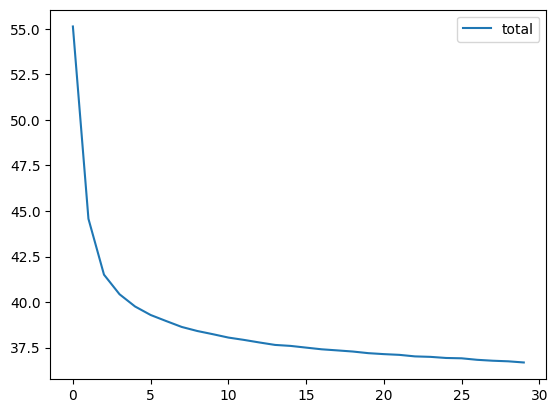

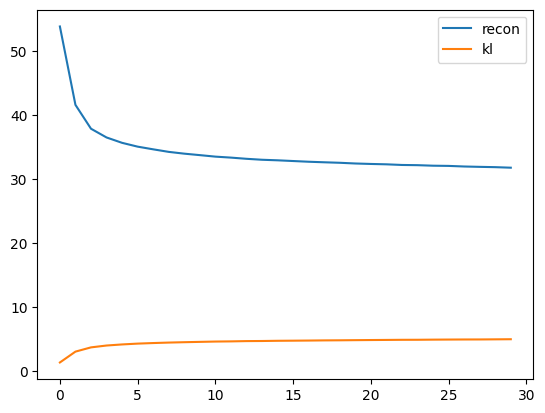

In [42]:
plt.plot(t.history.history["total_loss"], label="total")
plt.legend()
plt.show()
plt.plot(t.history.history["reconstruction_loss"], label="recon")
plt.plot(t.history.history["kl_term"], label="kl")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


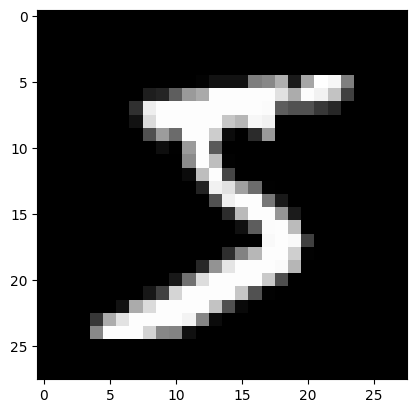

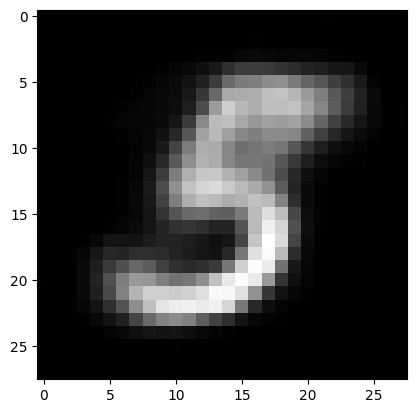

In [43]:
i = 0
recon, _, _, _ = ae.predict(x_train[i].reshape(-1, 28, 28, 1))
plt.imshow(x_train[i], cmap="gray")
plt.show()
plt.imshow(recon.reshape((28, 28)), cmap="gray")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step


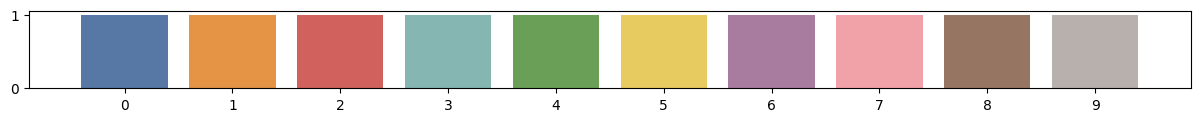

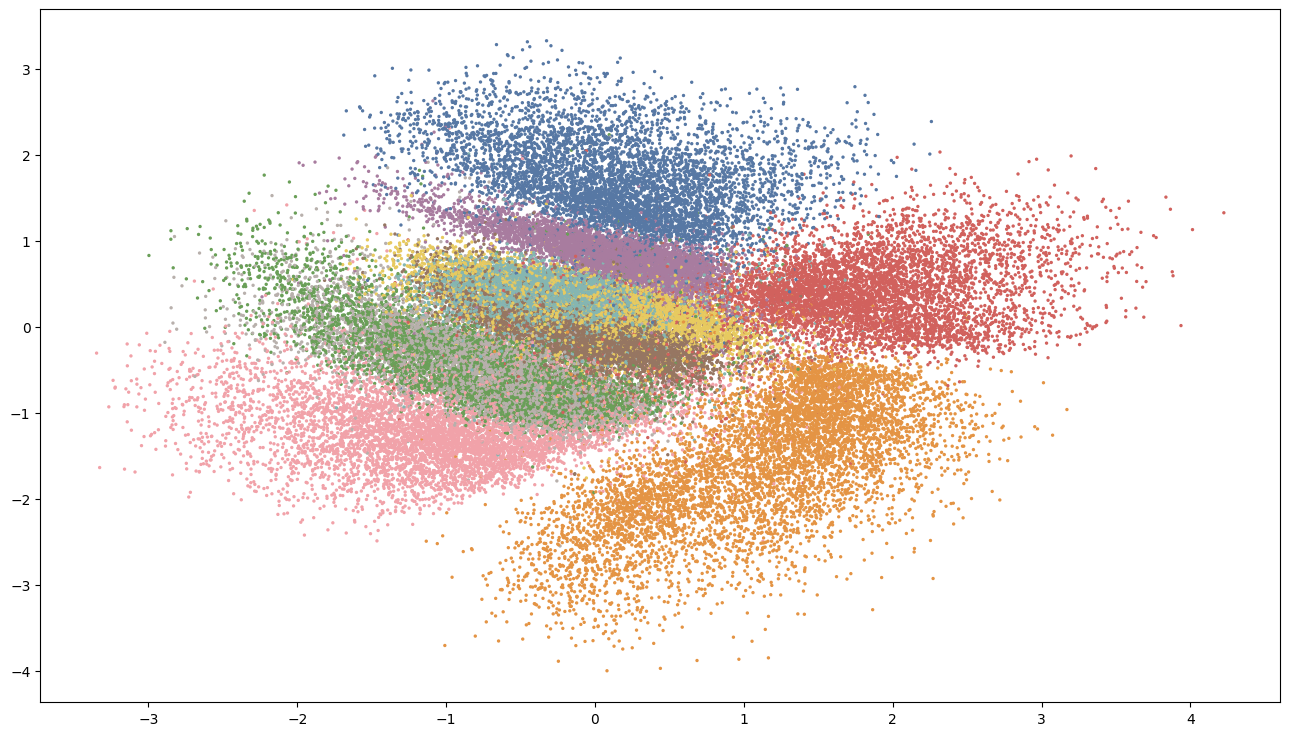

In [44]:
# now visualize the embedding space
def compute_embeddings(model, x_train, y_train):
	_, latents, _, _ = model.predict(x_train.reshape(-1, 28, 28, 1))
	return latents, y_train

def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=2, alpha=1)

latents, labels = compute_embeddings(ae, x_train, y_train)
plot_mnist(latents, labels)

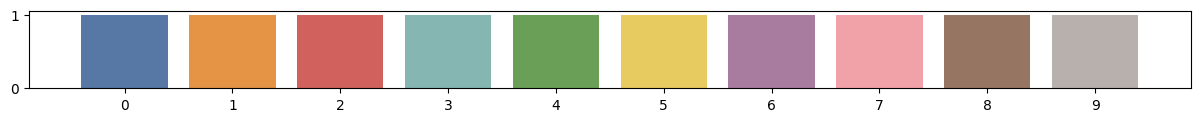

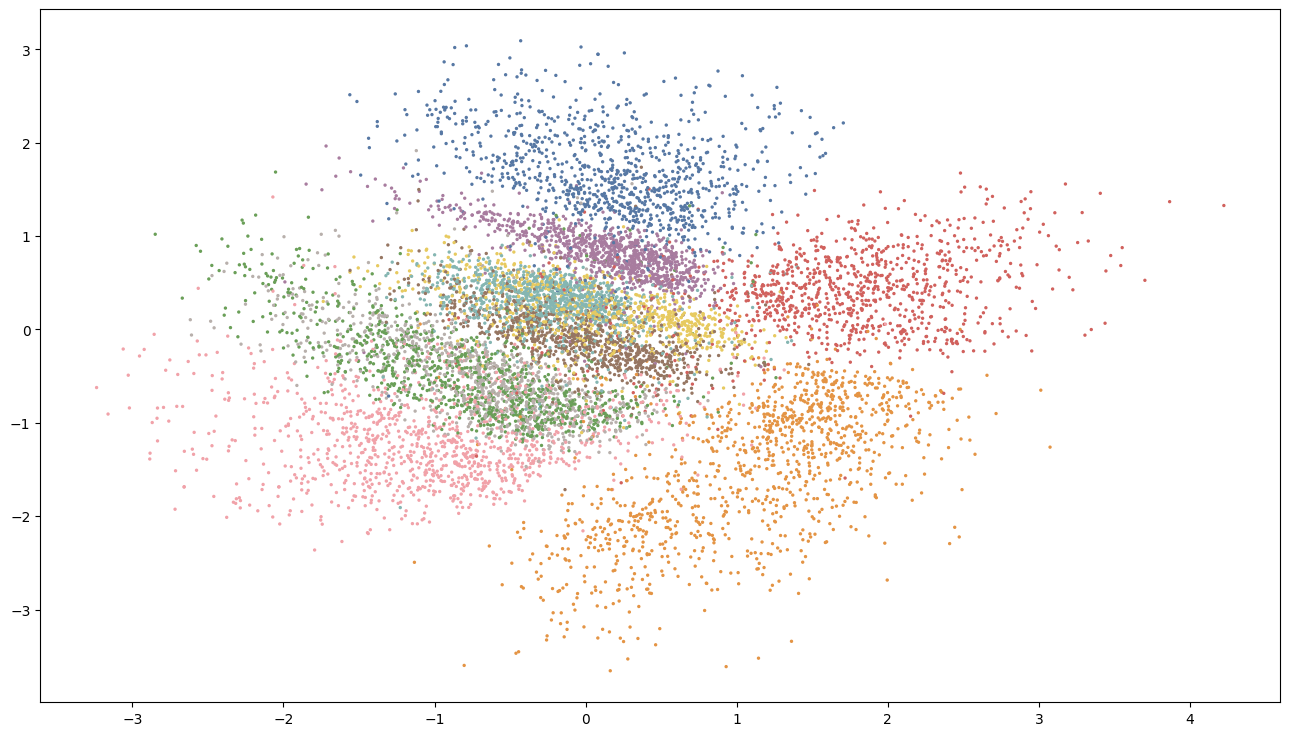

In [45]:
N = 10_000
plot_mnist(latents[:N], labels[:N])

In [46]:
import json
with open("./models/tfjs/latents-big.json", "w") as f:
	f.write(json.dumps({"points": latents[:N].tolist(), "labels": labels[:N].tolist()}))

In [47]:
tf.saved_model.save(ae.encoder, "models/encoder-big")
tf.saved_model.save(ae.decoder, "models/decoder-big")
tfjs.converters.convert_tf_saved_model("models/encoder-big", "models/tfjs/encoder-big")
tfjs.converters.convert_tf_saved_model("models/decoder-big", "models/tfjs/decoder-big")

INFO:tensorflow:Assets written to: models/encoder-big/assets


INFO:tensorflow:Assets written to: models/encoder-big/assets


INFO:tensorflow:Assets written to: models/decoder-big/assets


INFO:tensorflow:Assets written to: models/decoder-big/assets
2024-09-07 18:14:49.106507: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-09-07 18:14:49.311140: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
